# Descomposicion
---

1.**Objetivo:** queremos identificar a los operadores que no estan cumpliendo con la estandarización del servicio de CallMeMaybe, utilizando métricas de llamadas perdidas y el tiempo de espera. Esto permitira tomar acciones correctivas para mejorar la calidad del servicio y aumentar la satisfacción del cliente.

2.**¿A quien van dirigidos los resultados?** A los supervisores de CallMe Maybe, a los clientes, y al equipo de gestión de la compañía. 

3.**¿Que decisión se tomará con respecto al análisis?** 
- Se podrá tomar decisiones sobre la capacitación adicional de los operadores
- Reasignar llamadas.
- Ajustes en los planes tarifarios
- Remover operadores que de manera consistente no cumplan con los estándares.

4.**Especificar los detalles de un operador ineficaz.**
- Alto número de llamadas perdidas.
- Alto promedio de espera.
- Bajo número de llamadas salientes en comparación con otros operadores con perfiles similares 

 ---

 **Hipótesis 1**
 - Los operadores con alta tasa de llamadas perdidas tienen menor desempeño.

 **Hipótesis 2**

 - Existe una diferencia significativa en el tiempo de espera promedio entre los operadores lentos y rápidos.  

 **Convertir las hipótesis en un plan de accion claro.** 

 -Análisis exploratorio de datos. Verificar la consistencia de los datos (tipos de datos, valores faltantes, valores atipicos o outliers)

 - Explorar datos: calcular estadisticas descriptivas para cada variable(mediana, media, desviación estándar). Identificar correlaciones entre variables. Identificar operadores ineficaces.
 - Calcular métricas clave: calcular la tasa de llamadas perdidas, tiempo de espera promedio, número de llamadas salientes por operador. Crear una clasificación  de estos operadores en función  de estas métricas.
 - Visualizar resultados: crear gráficos para comparar el desempeño de los operadores.
 - Interpretar resultados: Evaluar si los resultdos obtenidos respladan o rechazan las hipótesis planteadas. 


## Paso 1. Cargar datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu

In [2]:
df_llamadas = pd.read_csv('/datasets/telecom_dataset_us.csv') 
df_clientes = pd.read_csv('/datasets/telecom_clients_us.csv')

In [3]:
df_llamadas.head()


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
df_llamadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


## Paso 2. Limpieza de Datos

### Convertir tipo de datos

In [5]:
df_llamadas['date'] = pd.to_datetime(df_llamadas['date'],format='%Y-%m-%d')
df_llamadas['date'] = df_llamadas['date'].dt.tz_convert('UTC')
df_llamadas['date_dt'] = pd.to_datetime(df_llamadas['date'].dt.date) 
df_llamadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   user_id              53902 non-null  int64              
 1   date                 53902 non-null  datetime64[ns, UTC]
 2   direction            53902 non-null  object             
 3   internal             53785 non-null  object             
 4   operator_id          45730 non-null  float64            
 5   is_missed_call       53902 non-null  bool               
 6   calls_count          53902 non-null  int64              
 7   call_duration        53902 non-null  int64              
 8   total_call_duration  53902 non-null  int64              
 9   date_dt              53902 non-null  datetime64[ns]     
dtypes: bool(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.8+ MB


In [6]:
#Verifico que los datos sean sensibles(revisando sus valores unicos)
df_llamadas['internal'].unique()

array([False, True, nan], dtype=object)

In [7]:
#Con indexacion logica booleana visualizo los valores ausentes 
condicion = df_llamadas['internal'].isna()
df_llamadas[condicion]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_dt
1007,166405,2019-09-17 21:00:00+00:00,in,NaN,NaN,True,1,0,59,2019-09-17
1090,166405,2019-09-30 21:00:00+00:00,in,NaN,NaN,True,1,0,1,2019-09-30
1864,166406,2019-08-19 21:00:00+00:00,in,NaN,NaN,True,1,0,36,2019-08-19
1924,166406,2019-09-01 21:00:00+00:00,in,NaN,879898.0,False,1,2,9,2019-09-01
6210,166541,2019-09-25 21:00:00+00:00,in,NaN,908960.0,False,1,393,423,2019-09-25
...,...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-08 21:00:00+00:00,in,NaN,NaN,True,6,0,14,2019-11-08
52590,168361,2019-11-12 21:00:00+00:00,in,NaN,NaN,True,2,0,6,2019-11-12
52621,168361,2019-11-13 21:00:00+00:00,in,NaN,NaN,True,1,0,2,2019-11-13
53717,168579,2019-11-08 21:00:00+00:00,in,NaN,NaN,True,1,0,18,2019-11-08


In [8]:
condicion.mean()

0.0021706059144373123

In [9]:
#Reemplazo los valores ausentes
df_llamadas['internal'] = df_llamadas['internal'].fillna(False)

In [10]:
#Los Verifico
df_llamadas['internal'].unique()

array([False,  True])

In [11]:
df_llamadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   user_id              53902 non-null  int64              
 1   date                 53902 non-null  datetime64[ns, UTC]
 2   direction            53902 non-null  object             
 3   internal             53902 non-null  bool               
 4   operator_id          45730 non-null  float64            
 5   is_missed_call       53902 non-null  bool               
 6   calls_count          53902 non-null  int64              
 7   call_duration        53902 non-null  int64              
 8   total_call_duration  53902 non-null  int64              
 9   date_dt              53902 non-null  datetime64[ns]     
dtypes: bool(2), datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.4+ MB


In [12]:
df_clientes.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [13]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [14]:
#Convertimos a formato fecha
df_clientes['date_start'] = pd.to_datetime(df_clientes['date_start']) 

In [15]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


### Examinar valores ausentes

In [16]:
df_llamadas.isna().sum()

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
date_dt                   0
dtype: int64

In [17]:
df_llamadas['operator_id'].isna().sum() / df_llamadas.shape[0] 

0.15160847463915997

In [18]:
df_llamadas['operator_id'].fillna('unknown', inplace = True)
df_llamadas.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
date_dt                0
dtype: int64

## Paso 3. Analisis de Datos

In [19]:
df_llamadas.describe()

,user_id,calls_count,call_duration,total_call_duration
count,53902.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,16.451245,866.684427,1157.133297
std,598.883775,62.917170,3731.791202,4403.468763
min,166377.000000,1.000000,0.000000,0.000000
25%,166782.000000,1.000000,0.000000,47.000000
50%,167162.000000,4.000000,38.000000,210.000000
75%,167819.000000,12.000000,572.000000,902.000000
max,168606.000000,4817.000000,144395.000000,166155.000000


De acuerdo a la estadistica reflejada podemos observar que existe una gran variabilidad en el numero de llamadas, la duracion de las llamadas y la duracion total de las llamadas por usuario, esto sugiere que tenemos una poblacion de ussuarios tiene una poblacion bastante hetereogena en terminos a su comportamiento de llamadas.

Posibles outliers, los valores minimos y maximos de call_duration y total_call_duration, sugieren presencia de outliers  


In [20]:
#Calcular el IQR y los limites para identificar outliers

Q1 = df_llamadas['call_duration'].quantile(0.25)
Q3 = df_llamadas['call_duration'].quantile(0.75)

IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print("Limite Inferior", lower_limit)
print("Limite Superior", upper_limit)

Limite Inferior -858.0
Limite Superior 1430.0


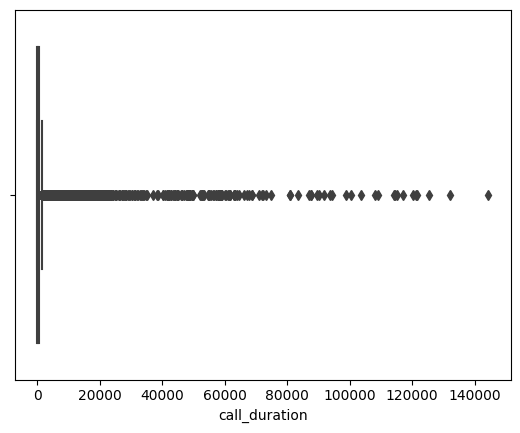

In [21]:
sns.boxplot(x = 'call_duration', data = df_llamadas)
plt.show()

In [22]:
outliers = df_llamadas[(df_llamadas['call_duration'] < lower_limit) | (df_llamadas['call_duration'] > upper_limit)]
outliers.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_dt
21,166377,2019-08-08 21:00:00+00:00,out,False,880028.0,False,17,1603,1725,2019-08-08
24,166377,2019-08-11 21:00:00+00:00,out,False,880028.0,False,20,2074,2191,2019-08-11
41,166377,2019-08-13 21:00:00+00:00,out,False,880028.0,False,18,2686,2782,2019-08-13
43,166377,2019-08-13 21:00:00+00:00,out,False,880026.0,False,10,1567,1654,2019-08-13
44,166377,2019-08-13 21:00:00+00:00,out,False,880026.0,False,10,1567,1654,2019-08-13


In [23]:
#Calculo los percentiles 95 para ambas columnas
call_duration_95 = np.percentile(df_llamadas['call_duration'], 95)
total_call_duration_95 = np.percentile(df_llamadas['total_call_duration'], 95)
print(call_duration_95)
print(total_call_duration_95)

3739.949999999997
4540.0


In [24]:
#Calculo el numero de llamdas que son superiores al percentil 95
call_duration_perc = df_llamadas[df_llamadas['call_duration']  > call_duration_95].shape[0] 
total_call_duration_perc = df_llamadas[df_llamadas['total_call_duration'] > total_call_duration_95].shape[0]
print("Numrero de llamadas con duracion superior al percentil 95:", call_duration_perc)
print("Duracion total de llamadas superior al percentil 95:", total_call_duration_perc)



Numrero de llamadas con duracion superior al percentil 95: 2696
Duracion total de llamadas superior al percentil 95: 2695


In [25]:
#Categorizar llamadas
df_llamadas['tipos_de_llamadas'] = np.where(df_llamadas['call_duration'] > call_duration_perc, 'Llamada Larga', 'Llamada Estandar')
df_llamadas.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_dt,tipos_de_llamadas
0,166377,2019-08-03 21:00:00+00:00,in,False,unknown,True,2,0,4,2019-08-03,Llamada Estandar
1,166377,2019-08-04 21:00:00+00:00,out,True,880022.0,True,3,0,5,2019-08-04,Llamada Estandar
2,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,True,1,0,1,2019-08-04,Llamada Estandar
3,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,False,1,10,18,2019-08-04,Llamada Estandar
4,166377,2019-08-04 21:00:00+00:00,out,False,880022.0,True,3,0,25,2019-08-04,Llamada Estandar


In [26]:
#Creo un dataset sin outliers
df_llamadas_2 = df_llamadas[(df_llamadas['call_duration'] <= call_duration_perc) & (df_llamadas['total_call_duration'] <= total_call_duration_perc)]
df_llamadas_2.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_dt,tipos_de_llamadas
0,166377,2019-08-03 21:00:00+00:00,in,False,unknown,True,2,0,4,2019-08-03,Llamada Estandar
1,166377,2019-08-04 21:00:00+00:00,out,True,880022.0,True,3,0,5,2019-08-04,Llamada Estandar
2,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,True,1,0,1,2019-08-04,Llamada Estandar
3,166377,2019-08-04 21:00:00+00:00,out,True,880020.0,False,1,10,18,2019-08-04,Llamada Estandar
4,166377,2019-08-04 21:00:00+00:00,out,False,880022.0,True,3,0,25,2019-08-04,Llamada Estandar


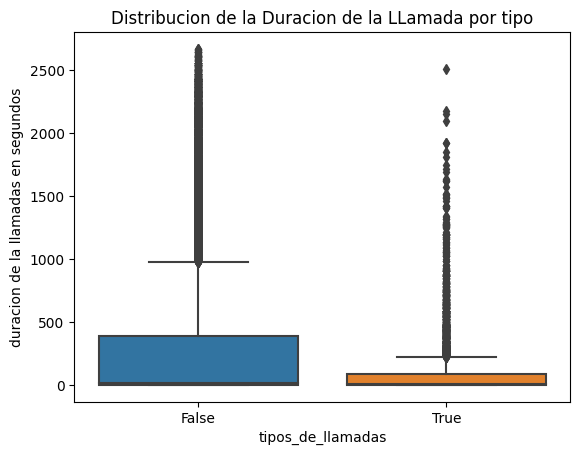

In [27]:
sns.boxplot(x = 'internal', y = 'call_duration', data = df_llamadas_2)
plt.xlabel('tipos_de_llamadas')
plt.ylabel('duracion de la llamadas en segundos')
plt.title('Distribucion de la Duracion de la LLamada por tipo')
plt.show()

Las llamadas internas presentan una duracion sfignificativamente mayor que las externas. Esto sugiere que las interacciones entre operadores y clientes suelen requerir mas tiempo para resolverse.

In [28]:
#Filtro las llamadas de la semana del 20 al 27 de noviembre de 2019
df_semana = df_llamadas_2[(df_llamadas_2['date_dt'] >= '2019-11-20') & (df_llamadas_2['date_dt'] <= '2019-11-27')]
df_semana.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_dt,tipos_de_llamadas
526,166377,2019-11-20 21:00:00+00:00,in,False,880028.0,False,2,349,354,2019-11-20,Llamada Estandar
527,166377,2019-11-20 21:00:00+00:00,out,False,880026.0,False,6,391,428,2019-11-20,Llamada Estandar
528,166377,2019-11-20 21:00:00+00:00,out,False,880028.0,True,17,0,427,2019-11-20,Llamada Estandar
529,166377,2019-11-20 21:00:00+00:00,out,False,880026.0,True,2,0,14,2019-11-20,Llamada Estandar
530,166377,2019-11-20 21:00:00+00:00,in,False,880026.0,False,1,70,81,2019-11-20,Llamada Estandar


In [29]:
#Agrupo los datos por dia y calculo la duracion promedio de las llamadas

df_agrupacion = df_semana.groupby('date_dt')['call_duration'].mean().reset_index()
df_agrupacion.head()

,date_dt,call_duration
0,2019-11-20,320.581308
1,2019-11-21,298.545709
2,2019-11-22,222.536082
3,2019-11-23,259.792254
4,2019-11-24,303.006341


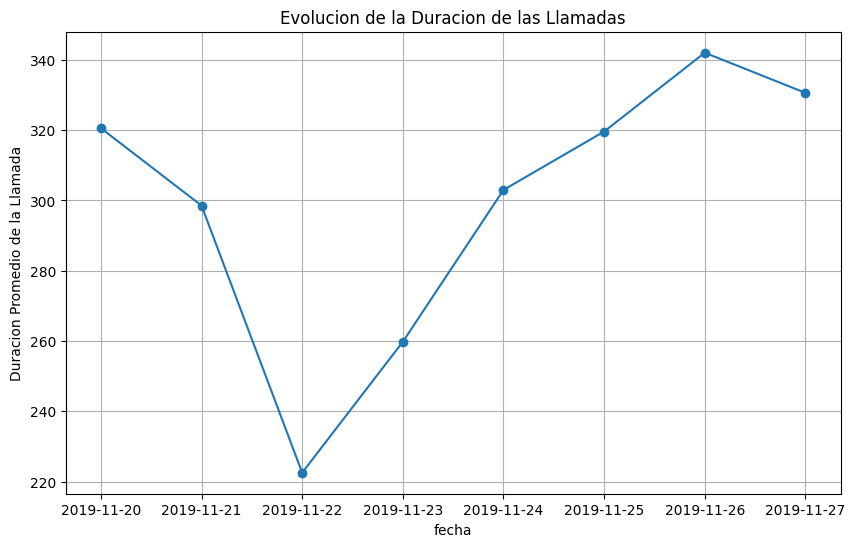

In [30]:
plt.figure(figsize=(10,6))
plt.plot(df_agrupacion['date_dt'],df_agrupacion['call_duration'], marker = 'o')
plt.xlabel('fecha')
plt.ylabel('Duracion Promedio de la Llamada')
plt.title('Evolucion de la Duracion de las Llamadas')
plt.grid(True)
plt.show()

La duracion promedio de las llamadas presento un patron interesante durante la semana del 20 al 27 de noviembre. Se observa una dismucion inicial, seguida de un incremento sostenido. Este comportamiento sugiere la posble influencia de factores externos, como promociones, campañas, o cambios en los procesos internos, que podrin haber afectado la complejidad y duracion de las interacciones ccon los clientes.

La eliminación de los outliers en las coumnas en las columnas en las columnas call_duration y total_call_duration ha resultado en una reduccion significativa de la desviación estándar, lo que indica una menor dispersión de los
datos. Al establecer un límite en el percentil 95 y eliminar los valores superiores, se ha logrado
obtener una distribución de datos más homogénea, facilitando así el análisis y la interpretación de
los resultados.

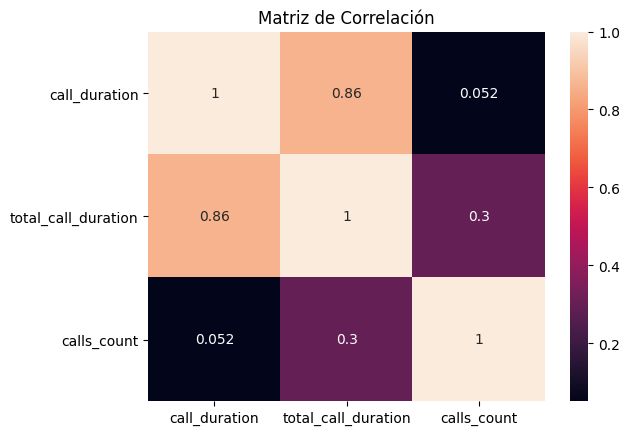

In [31]:
#Crear matriz de correlacion
columnas_numericas = ['call_duration','total_call_duration','calls_count']
df_numericas_continuas = df_llamadas_2[columnas_numericas]
# Calcular la matriz de correlación
cm = df_numericas_continuas.corr()
# Visualizar la matriz de correlación
sns.heatmap(cm, annot=True)
plt.title("Matriz de Correlación")
plt.show()

La matriz de correlación muestra una fuerte relación positiva entre la duración de las llamadas
individuales (call_duration) y la duración total de las llamadas (total_call_duration), lo que es
esperable. Sin embargo, la relación entre el número total de llamadas (calls_count) y las otras dos variables es más débil, sugiriendo que la eficiencia de los operadores podría influir en la duración
total de las llamadas, independientemente del número de ellas. También podría sugerir que los
usuarios es
están teniendo dificultades para resolver sus problemas en una sola llamada.

In [32]:
# Agrupar por operador y calcular la tasa de llamadas perdidas
grouped_data = df_llamadas_2.groupby('operator_id').agg(missed_call_rate=('is_missed_call','mean'))

# Ordenar por tasa de llamadas perdidas de mayor a menor
sorted_data = grouped_data.sort_values(by='missed_call_rate', ascending=False)

# Establecer umbral
llamadas_perdidas_limite= 0.30
# Identificar operadores ineficientes
inefficient_operators = sorted_data[sorted_data['missed_call_rate'] > llamadas_perdidas_limite]

# Contar los operadores ineficientes
num_inefficient_operators = len(inefficient_operators)
print("Número de operadores con alto porcentaje de llamadas perdidas: " , num_inefficient_operators)

# Mostrar los operadores ineficientes
print(inefficient_operators)

Número de operadores con alto porcentaje de llamadas perdidas:  640
             missed_call_rate
operator_id                  
919376.0             1.000000
905480.0             1.000000
955068.0             1.000000
919504.0             1.000000
945308.0             1.000000
...                       ...
943066.0             0.303030
962268.0             0.303030
925826.0             0.302521
900826.0             0.301676
906400.0             0.301205

[640 rows x 1 columns]


In [33]:
df_llamadas_2['operator_id'].nunique()

1091

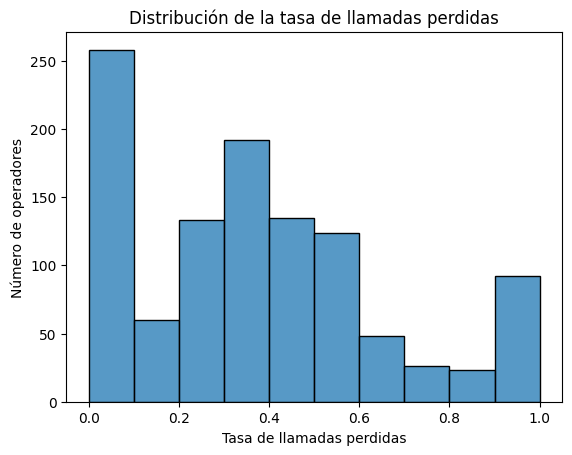

In [34]:
# Histograma
sns.histplot(data=sorted_data, x='missed_call_rate', bins=10)
plt.title('Distribución de la tasa de llamadas perdidas')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Número de operadores')
plt.show()

La mayoría de los operadores presentan una tasa de llamadas perdidas baja, concentrándose en
el rango entre 0 y 0.4. Sin embargo, existe un grupo considerable de operadores con tasas más
elevadas, lo que sugiere la necesidad de implementar acciones para mejorar la eficiencia en la
atención al cliente.

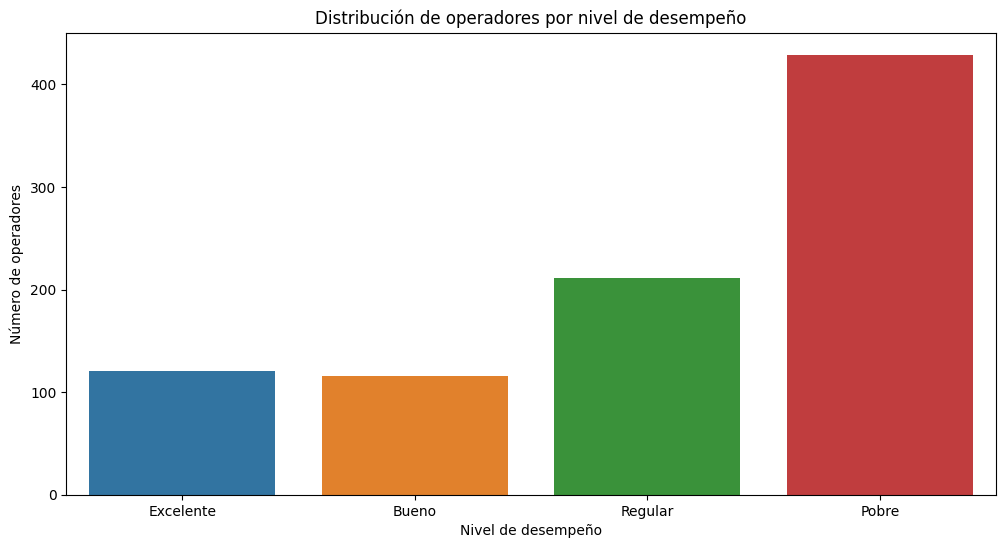

In [35]:
# Definir los rangos de desempeño para mejor visibilidad de patrones
bins = [0, 0.2, 0.3, 0.4, 1]
labels = ['Excelente', 'Bueno','Regular', 'Pobre']
# Crear una nueva columna con los rangos de desempeño
sorted_data['desempeño'] = pd.cut(sorted_data['missed_call_rate'], bins=bins, labels=labels)
# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.countplot(x='desempeño', data=sorted_data, order=labels)
plt.title('Distribución de operadores por nivel de desempeño')
plt.xlabel('Nivel de desempeño')
plt.ylabel('Número de operadores')
plt.show()

Si tenemos 1093 operadores en total y 635 tienen una tasa de llamadas perdidas superior al 30%,
estamos hablando de aproximadamente el 58% del equipo. Esto es un porcentaje considerable y
sugiere un problema sistémico más allá de casos individuales.
Impacto que representa para el negocio una tasa de llamadas perdidas tan alta puede tener un
choque negativo significativo en la reputación de la empresa, la satisfacción del cliente y, en última
instancia, en los ingresos.
Los clientes que no pueden comunicarse con un agente pueden optar por buscar los servicios de la competencia.
El análisis de la tasa de llamadas perdidas por operador revela una amplia gama de desempeños.
Si bien la mayoría de los operadores mantienen tasas bajas, un grupo significativo presenta tasas
significativamente más altas. Es necesario investigar las causas de estas diferencias, como la experi-
encia del operador, la complejidad de las llamadas o problemas técnicos, para implementar acciones
correctivas y garantizar un servicio de calidad
El gráfico de barras evidencia una clara necesidad de implementar programas de capacitación y
desarrollo para los operadores que se encuentran en las categorías “Regular” y “Pobre”.
Además, sería conveniente realizar un análisis más detallado de los factores que influyen en el desempeño de 14 cada operador, como la experiencia, la carga de trabajo o los recursos disponibles.

### Hipótesis 1: Los operadores con una alta tasa de llamadas entrantes perdidas tienen un menor desempeño


In [36]:
# Calcular métricas adicionales por operador 
grouped_data = df_llamadas_2.groupby('operator_id').agg(missed_call_rate=('is_missed_call', 'mean'), total_calls=('calls_count' , 'sum'), avg_call_duration=('call_duration' , 'mean'))
# Dividir los datos en dos grupos
high_missed_calls = grouped_data[grouped_data['missed_call_rate'] > 0.3]
low_missed_calls = grouped_data[grouped_data['missed_call_rate'] <= 0.3]
# Verificar normalidad de la duración promedio de las llamadas en ambos grupos
# Grupo con alta tasa de llamadas perdidas
stat, p = stats.shapiro(high_missed_calls['avg_call_duration'])
print('Grupo con alta tasa de llamadas perdidas:')
print('Estadístico de Shapiro-Wilk:', stat)
print('p-valor:', p)

if p > 0.05:
      print('Los datos se distribuyen aproximadamente de forma normal')
else:
      print('Los datos no se distribuyen de forma normal')
print('-------------------------------------------------------------')
# Grupo con baja tasa de llamadas perdidas
stat, p = stats.shapiro(low_missed_calls['avg_call_duration'])
print('Grupo con baja tasa de llamadas perdidas:')
print('Estadístico de Shapiro-Wilk:', stat)
print('p-valor:', p)
if p > 0.05:
    print('Los datos se distribuyen aproximadamente de forma normal')
else:
    print('Los datos no se distribuyen de forma normal')

Grupo con alta tasa de llamadas perdidas:
Estadístico de Shapiro-Wilk: 0.930423378944397
p-valor: 1.1581098999492804e-16
Los datos no se distribuyen de forma normal
-------------------------------------------------------------
Grupo con baja tasa de llamadas perdidas:
Estadístico de Shapiro-Wilk: 0.7741744518280029
p-valor: 1.8591873814248806e-24
Los datos no se distribuyen de forma normal


In [37]:
# Comparar el número total de llamadas atendidas (prueba de Mann-Whitney U)
U_stat, p_value = stats.mannwhitneyu(high_missed_calls['total_calls'],
low_missed_calls['total_calls'])
print('Comparación del número total de llamadas atendidas:')
print('Estadístico U:', U_stat)
print('p-valor:', p_value)
print('-------------------------------------------------------------')
# Comparar la duración promedio de las llamadas (prueba de Mann-Whitney U)
U_stat, p_value = stats.mannwhitneyu(high_missed_calls['avg_call_duration'],
low_missed_calls['avg_call_duration'])
print('Comparación de la duración promedio de las llamadas:')
print('Estadístico U:', U_stat)
print('p-valor:', p_value)

Comparación del número total de llamadas atendidas:
Estadístico U: 216626.0
p-valor: 3.2817986465623973e-45
-------------------------------------------------------------
Comparación de la duración promedio de las llamadas:
Estadístico U: 158121.5
p-valor: 0.007077236926018742


Los resultados obtenidos indican una relación clara y significativa entre la tasa de llamadas perdidas
y el desempeño de los operadores. Los operadores con una alta tasa de llamadas perdidas tienen
un menor volumen de trabajo y una menor duración promedio de las llamadas, lo que sugiere una
necesidad de mejorar sus prácticas y procesos.

In [38]:
 # Filtrar las llamadas entrantes
llamadas_entrantes = df_llamadas_2[df_llamadas_2['direction'] == 'in']
# Calcular el tiempo total de espera
tiempo_total_espera = llamadas_entrantes['total_call_duration'].sum() - llamadas_entrantes['call_duration'].sum()
# Calcular el número total de llamadas entrantes
numero_llamadas_entrantes = llamadas_entrantes['calls_count'].sum()
# Calcular el tiempo de espera promedio
tiempo_espera_promedio = tiempo_total_espera / numero_llamadas_entrantes
print("El tiempo de espera promedio para las llamadas entrantes es:", tiempo_espera_promedio, "segundos")

El tiempo de espera promedio para las llamadas entrantes es: 12.362706966026062 segundos


El tiempo de espera promedio para las llamadas entrantes es: 12.739733972839575
segundos

/tmp/ipykernel_1369/1780118756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llamadas_entrantes['tiempo_espera'] = llamadas_entrantes['total_call_duration'] - llamadas_entrantes['call_duration']


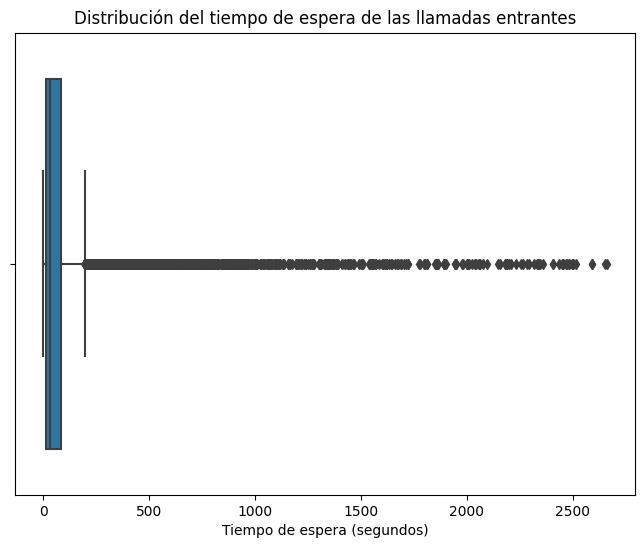

In [39]:
# Filtrar las llamadas entrantes
llamadas_entrantes = df_llamadas_2[df_llamadas_2['direction'] == 'in']
# Calcular el tiempo de espera para cada llamada
llamadas_entrantes['tiempo_espera'] = llamadas_entrantes['total_call_duration'] - llamadas_entrantes['call_duration']
# Grafico
plt.figure(figsize=(8,6))
sns.boxplot(x=llamadas_entrantes['tiempo_espera'])
plt.title('Distribución del tiempo de espera de las llamadas entrantes')
plt.xlabel('Tiempo de espera (segundos)')
plt.show()

La distribución del tiempo de espera y su promedio, muestra que la mayoría de las llamadas son
atendidas casi inmediatamente. No obstante, la presencia de valores atípicos indica que un grupo
de clientes experimenta esperas significativamente más largas. Es necesario investigar las causas de
estos tiempos de espera excesivos para optimizar el servicio.

## Hipotesis 2: Existe una diferencia significativa en el tiempo de espera promedio entre los operadores “lentos” y los “rápidos”


In [40]:
percentil_90_tiempo_espera = np.percentile(llamadas_entrantes['tiempo_espera'], 90)
percentil_90_tiempo_espera

206.0

In [41]:
percentil_90 = 235
# Crear una nueva columna para clasificar a los operadores lentos
llamadas_entrantes['operadores_lentos'] = llamadas_entrantes['tiempo_espera'] > percentil_90
llamadas_entrantes.groupby('operadores_lentos')['tiempo_espera'].describe()

/tmp/ipykernel_1369/562485085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llamadas_entrantes['operadores_lentos'] = llamadas_entrantes['tiempo_espera'] > percentil_90


,count,mean,std,min,25%,50%,75%,max
operadores_lentos,,,,,,,,
False,19138.0,48.096405,50.483960,0.0,12.0,30.0,65.00,235.0
True,1766.0,578.483012,453.812872,236.0,299.0,392.0,660.75,2661.0


El análisis revela que el 10% de los operadores superan el umbral de 235 segundos en tiempo de
espera promedio, lo que los clasifica como “lentos”. Estos operadores presentan un tiempo de espera
promedio casi 13 veces mayor que el resto del grupo.

In [42]:
# Crear una nueva columna para clasificar a los operadores rapidos
llamadas_entrantes['operadores_rapidos'] = llamadas_entrantes['tiempo_espera'] <= percentil_90
# Extraer los tiempos de espera para cada grupo
tiempos_lentos = llamadas_entrantes[llamadas_entrantes['operadores_lentos']]['tiempo_espera']
tiempos_rapidos = llamadas_entrantes[llamadas_entrantes['operadores_rapidos']]['tiempo_espera']
# Verificar normalidad para operadores lentos
stat, p = stats.shapiro(tiempos_lentos)
print('Operadores lentos:')
print('Estadístico de Shapiro-Wilk:', stat)
print('p-valor:', p)
if p > 0.05:
  print('Los datos se distribuyen aproximadamente de forma normal')
else:
  print('Los datos no se distribuyen de forma normal')

print('-------------------------------------------------------------')
# Verificar normalidad para operadores rápidos
stat, p = stats.shapiro(tiempos_rapidos)
print('Operadores rápidos:')
print('Estadístico de Shapiro-Wilk:', stat)
print('p-valor:', p)
if p > 0.05:
  print('Los datos se distribuyen aproximadamente de forma normal')
else:
  print('Los datos no se distribuyen de forma normal')

Operadores lentos:
Estadístico de Shapiro-Wilk: 0.7055096626281738
p-valor: 0.0
Los datos no se distribuyen de forma normal
-------------------------------------------------------------
Operadores rápidos:
Estadístico de Shapiro-Wilk: 0.8126936554908752
p-valor: 0.0
Los datos no se distribuyen de forma normal


/tmp/ipykernel_1369/550784469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llamadas_entrantes['operadores_rapidos'] = llamadas_entrantes['tiempo_espera'] <= percentil_90
/.venv/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [43]:
#Prueba de Mann-Whitney U
U1, p = mannwhitneyu(tiempos_lentos, tiempos_rapidos)
print('Estadístico U:', U1)
print('p-valor:', p)
if p < 0.05:
  print("Existe una diferencia significativa en los tiempos de espera entre los dos grupos.")
else:
  print("No se encontró una diferencia significativa.")

Estadístico U: 33797708.0
p-valor: 0.0
Existe una diferencia significativa en los tiempos de espera entre los dos grupos.


Los resultados obtenidos muestran de manera contundente que existe una diferencia significativa en
el desempeño de los operadores, evidenciada por los tiempos de espera. Los operadores clasificados
como ‘lentos’ presentaron un rendimiento significativamente inferior (p < 0.05) en comparación con
sus colegas.

Rechazamos la hipótesis nula (Donde NO hay una diferencia significativa). Esto significa que
podemos concluir con un alto grado de confianza que sí existe una diferencia significativa en los
tiempos de espera entre los dos grupos de operadores.

### Número de llamadas salientes por operador

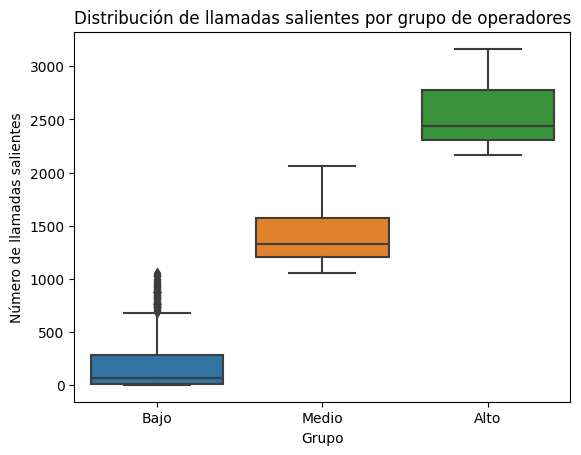

In [44]:
# Filtrar las llamadas salientes
llamadas_salientes = df_llamadas_2[df_llamadas_2['direction'] == 'out']
# Agrupar por operador y contar las llamadas
llamadas_por_operador = llamadas_salientes.groupby('operator_id')['calls_count'].sum().reset_index()
# Crear categorías basadas en cuantiles
labels = ['Bajo', 'Medio', 'Alto']
llamadas_por_operador['grupo'] = pd.cut(llamadas_por_operador['calls_count'], bins=3, labels=labels)
# Crear un boxplot para comparar la distribución por grupos
sns.boxplot(x='grupo', y='calls_count', data=llamadas_por_operador)
plt.title('Distribución de llamadas salientes por grupo de operadores')
plt.xlabel('Grupo')
plt.ylabel('Número de llamadas salientes')
plt.show()

Los resultados obtenidos indican una desigual distribución de la carga de trabajo entre los operadores. La alta concentración de llamadas en el grupo “Alto” sugiere la necesidad de redistribuir las tareas o proporcionar recursos adicionales a estos operadores. Además, el análisis del outlier en este grupo podría revelar oportunidades de optimización o áreas donde se requiere atención especial.

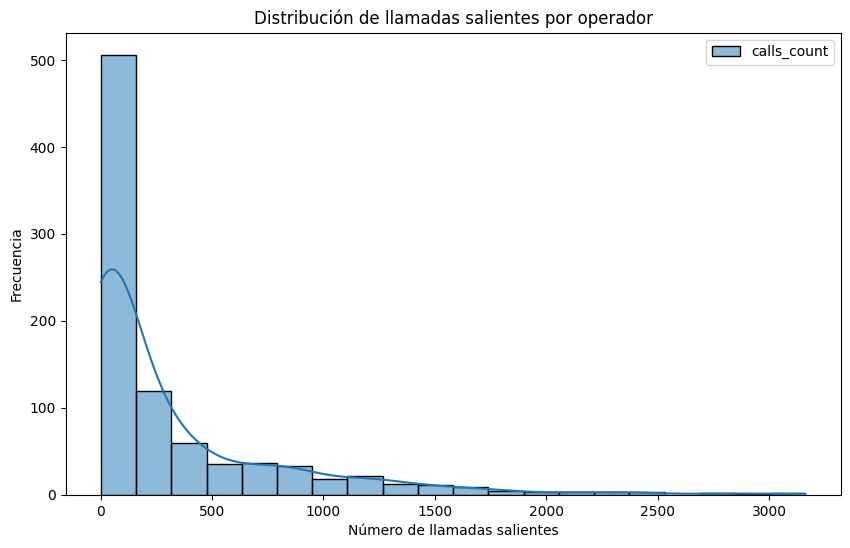

In [45]:
# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(data=llamadas_por_operador, bins=20, kde=True)
plt.title('Distribución de llamadas salientes por operador')
plt.xlabel('Número de llamadas salientes')
plt.ylabel('Frecuencia')
plt.show()

In [46]:
llamadas_por_operador.mean()

calls_count    321.146425
dtype: float64

In [47]:
percentil_25 = np.percentile(llamadas_por_operador['calls_count'], 25)
print("El percentil 25 de llamadas por operador es:", percentil_25)

El percentil 25 de llamadas por operador es: 12.0


Existe una gran disparidad en el número de llamadas salientes realizadas por cada operador. Donde el operador que más llamadas atiende, tiene un total de 4.921 de llamadas. Un pequeño grupo de operadores concentra un volumen significativamente mayor de llamadas en comparación con el resto del equipo. Hay un número considerable de operadores (221) que realizan muy pocas llamadas
salientes, por debajo de 12 llamadas, incluso algunos solo una. Esto podría indicar problemas de asignación de tareas, falta de capacitación o factores externos que afectan su productividad. Posible necesidad de reasignación, la concentración de llamadas en pocos operadores podría indicar una sobrecarga de trabajo para ellos y una posible sub utilización de otros. Podría ser necesario reasignar las tareas para distribuir la carga de trabajo de manera más equitativa.

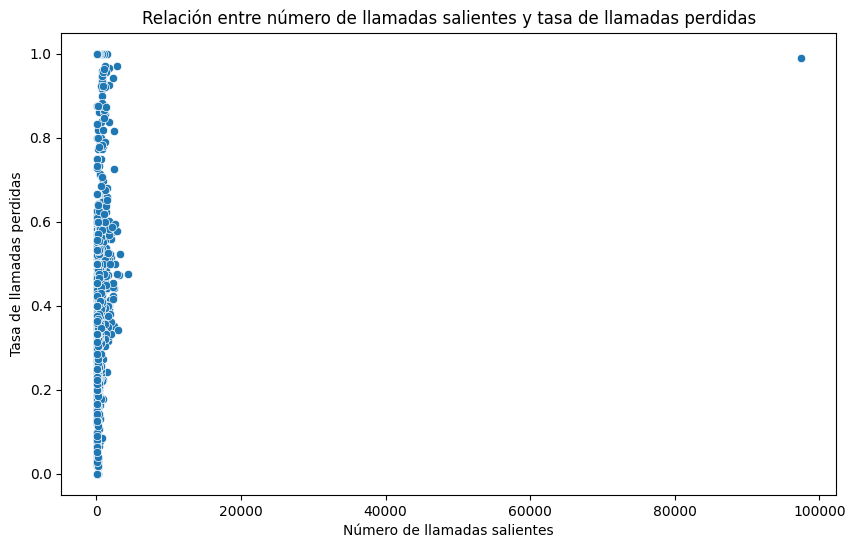

In [48]:
# Calcular la tasa de llamadas perdidas por operador
grouped_data = df_llamadas_2.groupby('operator_id').agg(calls_count= ('calls_count','sum'), missed_call_rate=('is_missed_call','mean'))
# Grafico
plt.figure(figsize=(10, 6))
sns.scatterplot(x='calls_count', y='missed_call_rate', data=grouped_data)
plt.title('Relación entre número de llamadas salientes y tasa de llamadas perdidas')
plt.xlabel('Número de llamadas salientes')
plt.ylabel('Tasa de llamadas perdidas')
plt.show()

No se observa una relación clara entre el número de llamadas salientes y la tasa de llamadas perdidas. Otros factores, como la complejidad de las llamadas o la disponibilidad de los agentes, podrían estar influyendo en la tasa de pérdidas.

## Conclusion y recomendaciones
El análisis exhaustivo de los datos de llamadas ha revelado una heterogeneidad significativa en el desempeño de los operadores de CallMeMaybe. Se identificaron brechas significativas en términos de volumen de llamadas, tiempos de espera, tasas de llamadas perdidas y eficiencia en la resolución de incidentes.

Los resultados evidencian que un porcentaje considerable de operadores no cumple con los estándares establecidos, lo que impacta directamente en la satisfacción del cliente y la reputación de la empresa. Las causas de este bajo desempeño son multifactoriales y abarcan desde la falta de capacitación y experiencia hasta problemas en la asignación de tareas y la gestión de recursos.

## Recomendaciones:

1. **Mejora de las condiciones laborales y el trato:** Reconocimiento y valoración: Implementar un programa de reconocimiento que valore las contribuciones de los operadores y celebre sus logros. Esto puede incluir bonos, días libres adicionales o simplemente un reconocimiento público. Clima laboral positivo: Fomentar un ambiente de trabajo colaborativo y respetuoso, donde los operadores se sientan valorados y apoyados. Esto puede incluir actividades de team building, canales de comunicación abiertos y la resolución de conflictos de manera justa y transparente. Flexibilidad: Evaluar la posibilidad de ofrecer horarios flexibles o jornadas reducidas, siempre que sea compatible con las necesidades del negocio. Esto puede ayudar a mejorar la conciliación de la vida laboral y personal y aumentar la satisfacción de los empleados. Programas de bienestar: Implementar programas de bienestar que promuevan la salud física y mental de los empleados, como clases de yoga, programas de nutrición o asistencia psicológica.
2. **Revisión de la remuneración:** Evaluación de salarios: Realizar un estudio de mercado para determinar si los salarios actuales son competitivos y justos en comparación con otras empresas del sector. Estructura salarial transparente: Establecer una estructura salarial clara y transparente, basada en el desempeño y la experiencia.
Incentivos por desempeño: Implementar un sistema de incentivos que recompense a los operadores por alcanzar metas y objetivos establecidos.

**Beneficios adicionales:**
Ofrecer beneficios adicionales como seguro médico, seguro de vida o descuentos en productos o servicios de la empresa.

3. **Fortalecimiento de la capacitación y el desarrollo:** Capacitación continua: Implementar un programa de capacitación continua que aborde las necesidades específicas de cada operador y las últimas tendencias del sector. Reconocimiento de certificaciones: Reconocer y recompensar a los operadores que obtengan certificaciones profesionales relacionadas con su trabajo.

**Mentoría:**
Implementar un programa de mentoría que permita a los operadores más experimentados compartir sus conocimientos con los nuevos empleados.

4. **Comunicación efectiva:** Canales de comunicación abiertos: Establecer canales de comunicación bidireccionales para que los operadores puedan expresar sus inquietudes y sugerencias.

**Encuestas de clima laboral:** Realizar encuestas de clima laboral de forma regular para identificar áreas de mejora y tomar medidas correctivas.

Al implementar estas recomendaciones, **CallMeMaybe** podrá mejorar significativamente la calidad de su servicio, aumentar la satisfacción del cliente y fortalecer su posición en el mercado. Es fundamental que la empresa se comprometa con un proceso de mejora continua y que invierta en el desarrollo de sus operadores para garantizar el éxito a largo plazo.
   
